# Task 2: Diverse Explanations

**Goal**: The goal of this task is to select a diverse set of explanations that are still necessary
and sufficient in terms of allowing someone to understand and fix a bug. Use readability and
semantic similarity to your ground truth (produced in Task-2) to find a set of explanations
that are maximally diverse.

**Objectives**: High readability, high semantic similarity, and high diversity of the
demographics/answer attributes

In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random



**Question 3.1 :** how would you measure diversity? E.g., entropy of each feature

In [58]:
#includes preprocessed data from mini project 02 and added answer.explanation plain text
preprocessed_df = pd.read_csv('data/exports/preprocessed_data.csv') 
#select correct answers only 
preprocessed_df = preprocessed_df[(preprocessed_df['GroundTruth'] == 1) & (preprocessed_df['TP'] == 1)]
preprocessed_df.drop(columns=['GroundTruth', 'Answer.option', 'TP', 'Answer.explanation_length'], inplace=True)
preprocessed_df.columns = preprocessed_df.columns.str.strip()


In [3]:
#print all column names and their index
for i, col in enumerate(preprocessed_df.columns):
    print(i, col)

0 FailingMethod
1 Answer.duration
2 Answer.confidence
3 Answer.difficulty
4 Answer.order
5 Answer.explanation
6 Code.LOC
7 Code.complexity
8 Worker.score
9 Worker.profession
10 Worker.yearsOfExperience
11 Worker.age
12 Worker.gender
13 Worker.country
14 Flesch_reading_ease
15 books
16 high school
17 no?
18 other
19 other as long as i can remember honestly
20 other at work
21 other autodidact
22 other books
23 other by myself from books
24 other diploma
25 other elementary school
26 other employer
27 other first robotics
28 other forever
29 other found a book
30 other had a book on basic when i was a kid
31 other hobby
32 other hobbyist
33 other i really dont remember a time when i couldnt
34 other instructional books
35 other java while on the job
36 other junior high computer class
37 other leanred more experts at work
38 other middle school
39 other mooc
40 other na
41 other on the job
42 other private
43 other private institute
44 other professional
45 other professionally
46 other 

In [66]:
from scipy.stats import entropy
from sklearn.metrics import pairwise_distances

def compute_diversity_scores(df, one_hot_start_index=14, bins=10):
    numerical_cols = [
        'FailingMethod',
        'Answer.duration',
        'Answer.confidence',
        'Answer.difficulty',
        'Answer.order',
        'Code.LOC',
        'Code.complexity',
        'Worker.score',
        'Worker.profession',
        'Worker.yearsOfExperience',
        'Worker.age',
        'Worker.gender',
        'Worker.country'
    ]
    
    # Jaccard Diversity Component
    one_hot_cols = df.columns[one_hot_start_index:]
    one_hot_data = df[one_hot_cols].astype(bool).to_numpy()

    # Compute the pairwise Jaccard distances and derive similarity
    jaccard_similarity = 1 - pairwise_distances(one_hot_data, metric="jaccard").mean()
    # jaccard_diversity is defined as 1 minus the similarity
    jaccard_diversity = 1 - jaccard_similarity

    # Entropy
    def compute_normalized_entropy(col, bins=bins):
        data = col.dropna()
        unique_vals = np.unique(data)
        if len(unique_vals) <= 1:
            return 0, 0# No variability => entropy is zero.
        
        # Use at most `bins` bins (or the number of unique values if lower)
        num_bins = min(bins, len(unique_vals))
        # The maximum possible entropy with num_bins equally likely bins is log(num_bins)
       
        max_entropy = np.log(num_bins)
        hist, _ = np.histogram(data, bins=num_bins)
        hist = hist.astype(float)
        if hist.sum() > 0:
            hist = hist / hist.sum()
        else:
            return 0, 0
        
        raw_entropy = entropy(hist)
        norm_entropy = raw_entropy / (max_entropy + 1e-10)
        norm_entropy = min(norm_entropy, 1)
        return raw_entropy, norm_entropy

    df_numerical = df[numerical_cols]
    raw_entropies = {}
    normalized_entropies = {}

    for col in df_numerical.columns:
        raw, norm = compute_normalized_entropy(df_numerical[col])
        raw_entropies[col] = raw
        normalized_entropies[col] = norm

    # avg the normalized entropies from all numerical features
    entropy_score = np.mean(list(normalized_entropies.values()))
    weight_numerical_features = len(numerical_cols) / (len(numerical_cols) + 2)
    weight_one_hot_encoded_features = 2 / (len(numerical_cols) + 2)
    
    final_diversity_score = (weight_numerical_features * entropy_score) + (weight_one_hot_encoded_features * jaccard_diversity)
    final_diversity_score = min(max(final_diversity_score, 0), 1)

    return {
        "normalized_entropies": normalized_entropies,
        "entropy_score": entropy_score,
        "jaccard_similarity": jaccard_similarity,
        "jaccard_diversity": jaccard_diversity,
        "final_diversity_score": final_diversity_score, 
    }, numerical_cols

results, numerical_cols = compute_diversity_scores(preprocessed_df)

print("Normalized Feature Entropy for non-hot-encoded features:")
for col, value in results["normalized_entropies"].items():
    print(f"{col}: {value:.3f}")

print("\nEntropy Score (averaged):", round(results["entropy_score"], 2))
print("\nJaccard Similarity for one-hot-encoded features:", round(results["jaccard_similarity"], 2))
print("Jaccard Diversity:", round(results["jaccard_diversity"], 2))
print("\nFinal Weighted Diversity Score:", round(results["final_diversity_score"], 2))


Normalized Feature Entropy for non-hot-encoded features:
FailingMethod: 0.594
Answer.duration: 0.230
Answer.confidence: 0.864
Answer.difficulty: 0.973
Answer.order: 0.927
Code.LOC: 0.317
Code.complexity: 0.353
Worker.score: 0.921
Worker.profession: 0.888
Worker.yearsOfExperience: 0.713
Worker.age: 0.783
Worker.gender: 0.758
Worker.country: 0.610

Entropy Score (averaged): 0.69

Jaccard Similarity for one-hot-encoded features: 0.38
Jaccard Diversity: 0.62

Final Weighted Diversity Score: 0.68


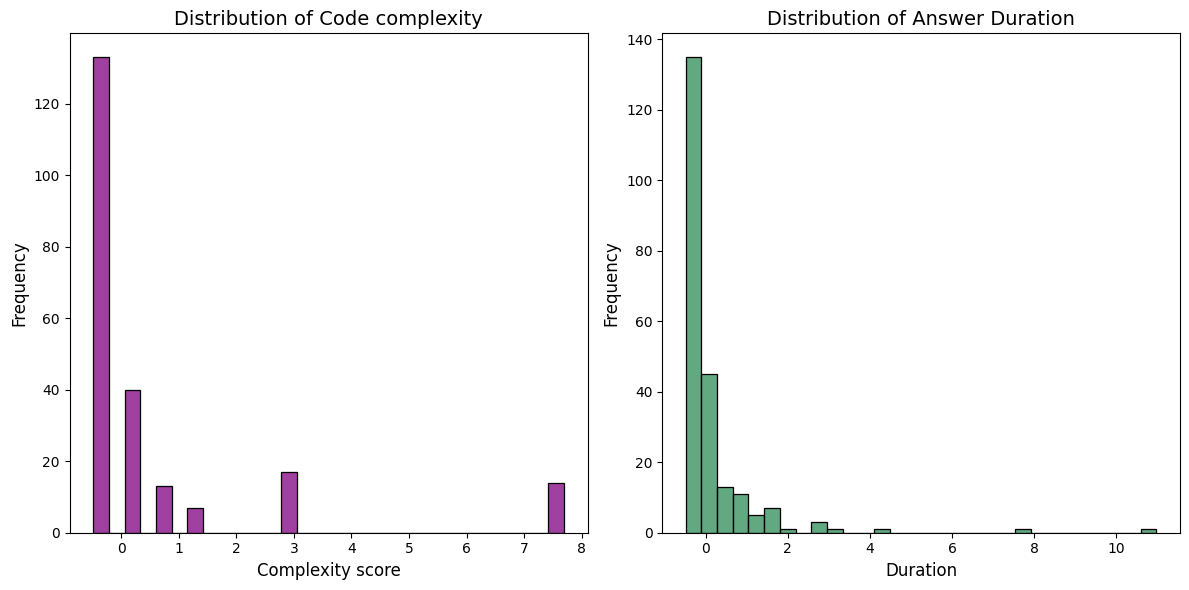

In [5]:
#ploting the distribution of features with low diversity (<=50)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(preprocessed_df['Code.complexity'], bins=30,  color='purple')
plt.title('Distribution of Code complexity', fontsize=14)
plt.xlabel('Complexity score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(preprocessed_df['Answer.duration'], bins=30,  color='seagreen')
plt.title('Distribution of Answer Duration', fontsize=14)
plt.xlabel('Duration', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('data/figures/answer_duration_code_complexity.png')
plt.tight_layout()
plt.show()



**Question 3.2 :** what is the max readability and semantic similarity independent of the
diversity?

In [6]:
#loading our ground truth explanations from mini project 2
path = 'data/llm_gt_explanations'

gt_explanations = {}
for file in os.listdir(path):
    if file.endswith('.txt'):
        with open(os.path.join(path, file)) as f:
            bug_number = int(file.split('_')[-1].split('.')[0])
            gt_explanations[bug_number] = f.read()


Readability 50th Percentile Threshold: 70.55
Semantic Similarity 50th Percentile Threshold: 0.5155762434005737
Number of explanations meeting both thresholds: 43


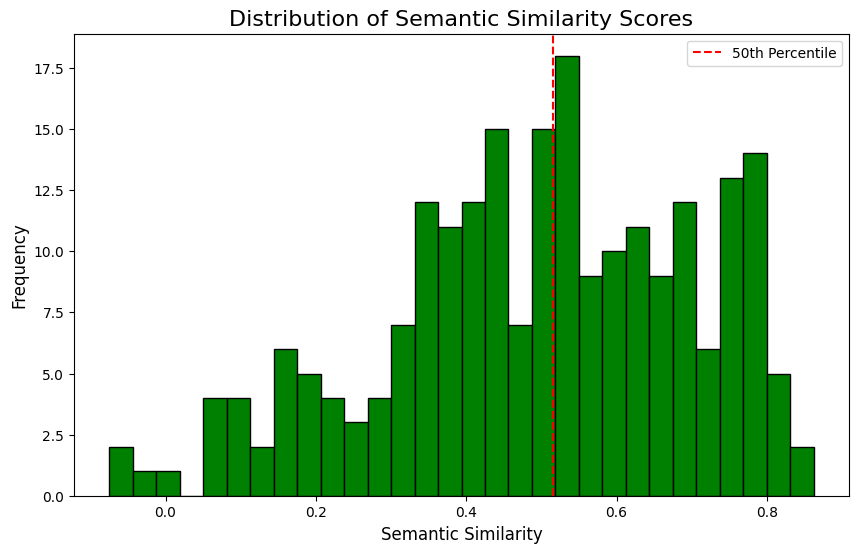

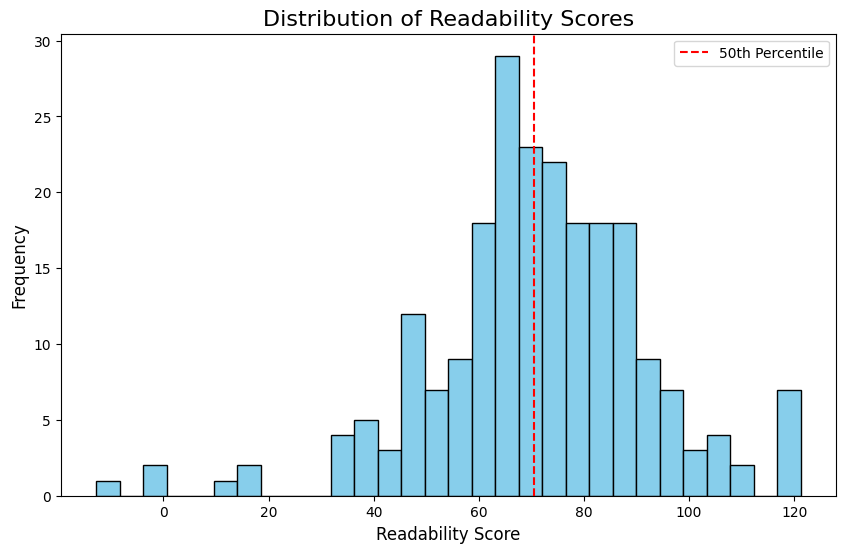

In [7]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from textstat import flesch_reading_ease

model = SentenceTransformer('all-mpnet-base-v2')

# semantic similarity for each row
similarities = {}
for index, row in preprocessed_df.iterrows():
    bug = row['FailingMethod']
    gt_exp = gt_explanations[bug]  # Ground truth explanation for this bug
    answer_exp = row['Answer.explanation']
    answer_vec = model.encode(answer_exp, convert_to_tensor=True)
    gt_vec = model.encode(gt_exp, convert_to_tensor=True)
    
    # cosine similarity
    similarity = cosine_similarity(answer_vec.reshape(1, -1), gt_vec.reshape(1, -1))
    similarities[index] = float(similarity[0][0])  # Convert tensor to float

preprocessed_df['semantic_similarity'] = preprocessed_df.index.map(similarities)

# Compute readability score
preprocessed_df['readability_score'] = preprocessed_df['Answer.explanation'].apply(flesch_reading_ease)

# Compute 50th percentile thresholds
readability_threshold = preprocessed_df['readability_score'].quantile(0.50)
similarity_threshold = preprocessed_df['semantic_similarity'].quantile(0.50)

print(f"Readability 50th Percentile Threshold: {readability_threshold}")
print(f"Semantic Similarity 50th Percentile Threshold: {similarity_threshold}")

# Function to extract subset meeting both thresholds
def extract_high_quality_subset(df, readability_thresh, similarity_thresh):
    """Extracts explanations that meet or exceed the readability and similarity thresholds."""
    subset = df[
        (df['readability_score'] >= readability_thresh) &
        (df['semantic_similarity'] >= similarity_thresh)
    ]
    return subset

high_quality_subset = extract_high_quality_subset(preprocessed_df, readability_threshold, similarity_threshold)


print(f"Number of explanations meeting both thresholds: {len(high_quality_subset)}")
plt.figure(figsize=(10, 6))
plt.hist(preprocessed_df['semantic_similarity'], bins=30, color='green', edgecolor='black')
plt.axvline(similarity_threshold, color='red', linestyle='dashed', label="50th Percentile")
plt.title('Distribution of Semantic Similarity Scores', fontsize=16)
plt.xlabel('Semantic Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.savefig('data/figures/semantic_similarity.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(preprocessed_df['readability_score'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(readability_threshold, color='red', linestyle='dashed', label="50th Percentile")
plt.title('Distribution of Readability Scores', fontsize=16)
plt.xlabel('Readability Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.savefig('data/figures/readability.png')
plt.show()

Length original dataset: 224
Length high_quality_subset: 43


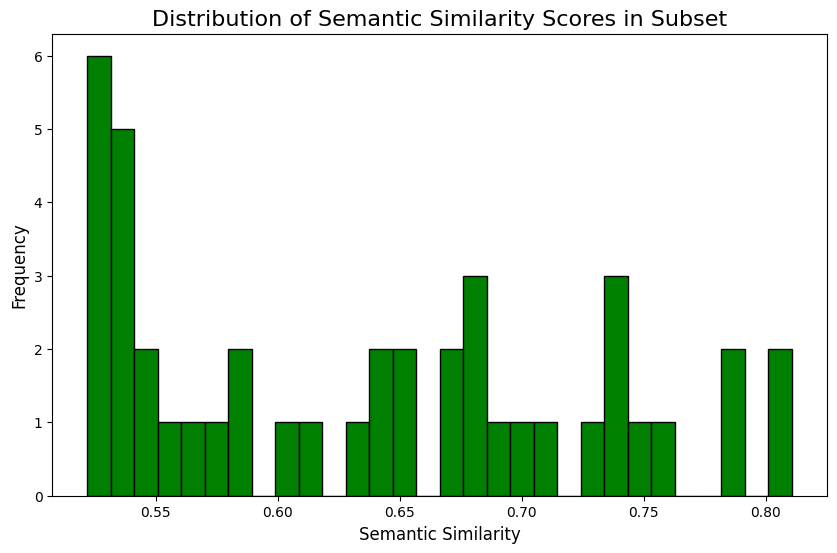

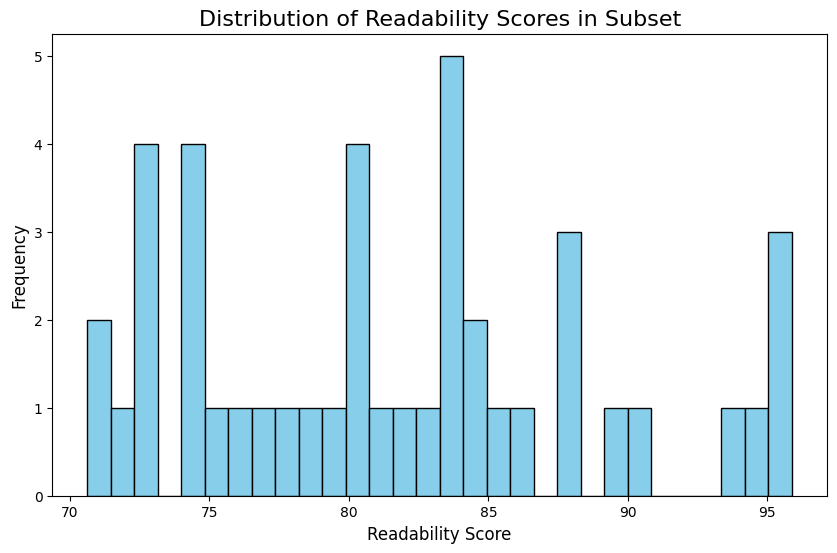

In [8]:
print(f'Length original dataset: {len(preprocessed_df)}')
print(f'Length high_quality_subset: {len(high_quality_subset)}')

plt.figure(figsize=(10, 6))
plt.hist(high_quality_subset['semantic_similarity'], bins=30, color='green', edgecolor='black')
plt.title('Distribution of Semantic Similarity Scores in Subset', fontsize=16)
plt.xlabel('Semantic Similarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('data/figures/semantic_similarity_subset.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(high_quality_subset['readability_score'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Readability Scores in Subset', fontsize=16)
plt.xlabel('Readability Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('data/figures/readability_subset.png')
plt.show()

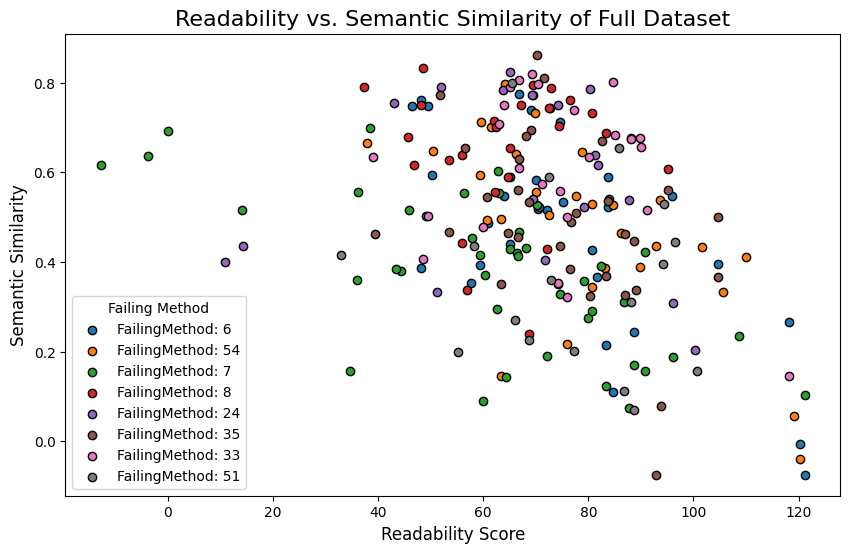

In [9]:
plt.figure(figsize=(10, 6))

for failing_method in preprocessed_df['FailingMethod'].unique():
    method_data = preprocessed_df[preprocessed_df['FailingMethod'] == failing_method]
    plt.scatter(method_data['readability_score'], method_data['semantic_similarity'],
                label=f'FailingMethod: {failing_method}', edgecolor='black')

plt.title('Readability vs. Semantic Similarity of Full Dataset', fontsize=16)
plt.xlabel('Readability Score', fontsize=12)
plt.ylabel('Semantic Similarity', fontsize=12)
plt.legend(title='Failing Method')
plt.savefig('data/figures/readability_vs_semantic_all_data.png')
plt.show()


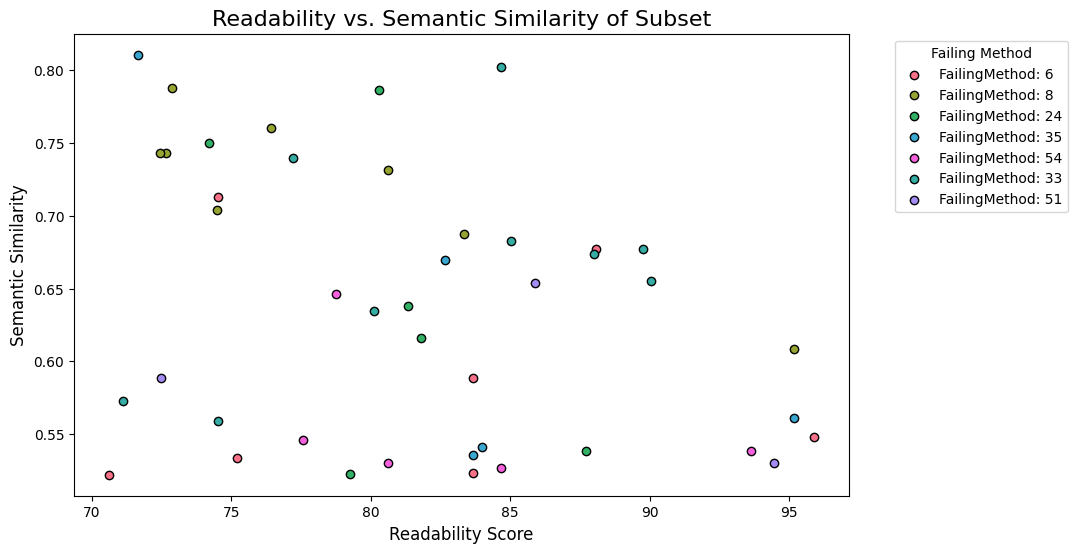

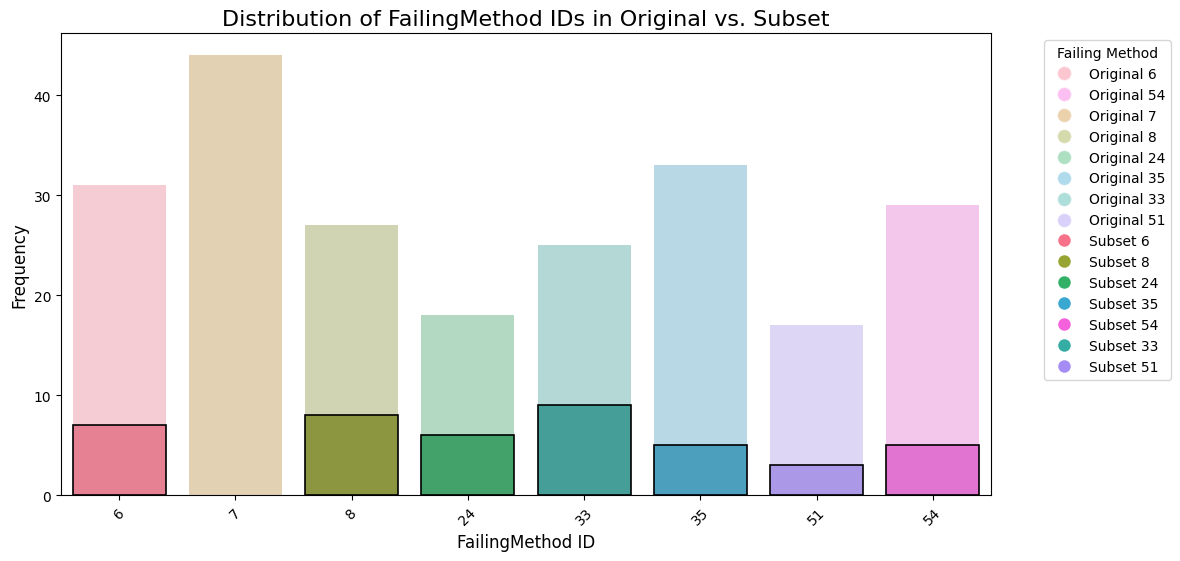

In [24]:
import warnings
warnings.filterwarnings('ignore')


# FailingMethod values from both datasets
all_methods = sorted(set(preprocessed_df['FailingMethod'].unique()) | set(high_quality_subset['FailingMethod'].unique()))


color_palette = sns.color_palette("husl", len(all_methods))
method_color_map = {method: color for method, color in zip(all_methods, color_palette)}

# Readability vs. Semantic Similarity
plt.figure(figsize=(10, 6))

for failing_method in high_quality_subset['FailingMethod'].unique():
    method_data = high_quality_subset[high_quality_subset['FailingMethod'] == failing_method]
    plt.scatter(method_data['readability_score'], method_data['semantic_similarity'],
                label=f'FailingMethod: {failing_method}', 
                edgecolor='black',
                color=method_color_map[failing_method])  # Assign the same color

plt.title('Readability vs. Semantic Similarity of Subset', fontsize=16)
plt.xlabel('Readability Score', fontsize=12)
plt.ylabel('Semantic Similarity', fontsize=12)
plt.legend(title='Failing Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('data/figures/readability_vs_semantic_subset.png', bbox_inches='tight')
plt.show()

# stacked histogram with original dataset and subset by FailingMethod
plt.figure(figsize=(12, 6))

# original data
sns.barplot(
    x=preprocessed_df['FailingMethod'], 
    y=preprocessed_df['FailingMethod'].map(preprocessed_df['FailingMethod'].value_counts()), 
    order=all_methods, 
    palette=[method_color_map[method] for method in all_methods],  
    alpha=0.4,  
)

#  subset
sns.countplot(
    x='FailingMethod', 
    data=high_quality_subset, 
    order=all_methods, 
    palette=[method_color_map[method] for method in all_methods], 
    edgecolor='black', 
    linewidth=1.2,
)

# handling the labeling
handles = []
labels = []
#original labels
for method in preprocessed_df['FailingMethod'].unique():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=method_color_map[method], markersize=10, alpha=0.4))  
    labels.append(f'Original {method}')

#subset labels
for method in high_quality_subset['FailingMethod'].unique():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=method_color_map[method], markersize=10))
    labels.append(f'Subset {method}')

plt.legend(handles=handles, labels=labels, title='Failing Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Distribution of FailingMethod IDs in Original vs. Subset', fontsize=16)
plt.xlabel('FailingMethod ID', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)  
plt.savefig('data/figures/failing_method_comparison.png', bbox_inches='tight')
plt.show()



In [13]:
high_quality_subset.to_csv('data/exports/high_quality_subset.csv', index=False)

**Question 3.3 :** what is the max diversity for (previously achieved) max semantic similarity ?
( compromising readability)

Sampling subsets of size 5...
Iteration 1/100 - Current Diversity Score: 0.6276
Iteration 2/100 - Current Diversity Score: 0.6260
Iteration 3/100 - Current Diversity Score: 0.8017
Iteration 4/100 - Current Diversity Score: 0.7693
Iteration 5/100 - Current Diversity Score: 0.7817
Iteration 6/100 - Current Diversity Score: 0.8527
Iteration 7/100 - Current Diversity Score: 0.6897
Iteration 8/100 - Current Diversity Score: 0.7854
Iteration 9/100 - Current Diversity Score: 0.6905
Iteration 10/100 - Current Diversity Score: 0.7481
Iteration 11/100 - Current Diversity Score: 0.6484
Iteration 12/100 - Current Diversity Score: 0.6988
Iteration 13/100 - Current Diversity Score: 0.7529
Iteration 14/100 - Current Diversity Score: 0.7269
Iteration 15/100 - Current Diversity Score: 0.7804
Iteration 16/100 - Current Diversity Score: 0.7113
Iteration 17/100 - Current Diversity Score: 0.7364
Iteration 18/100 - Current Diversity Score: 0.7227
Iteration 19/100 - Current Diversity Score: 0.6589
Iteration 

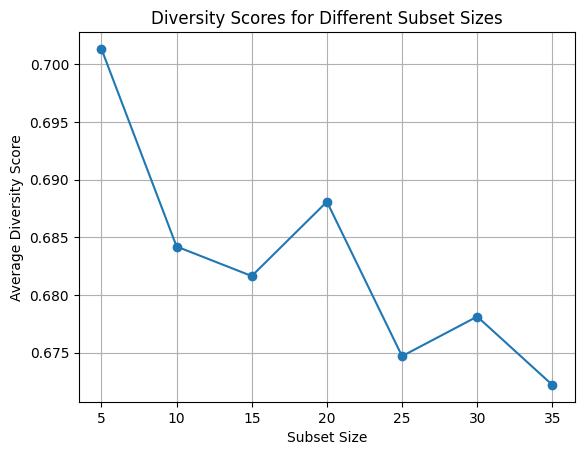

The final subset can be found in 'data/exports/final_subset.csv' and contains 5 entries.
It has a diversity score of 0.8526545974666649, an average readability score of 78.01, and an average semantic similarity score of 0.69.


In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

def find_high_diversity_subset(high_quality_subset, subset_sizes=[5, 10, 15, 20, 25, 30, 35], num_iterations=100):
    results = []  
    best_subset = None
    best_score = -float('inf')
    avg_readability_score = 0
    avg_semantic_similarity_score = 0

    for subset_size in subset_sizes:
        diversity_scores = []
        
        print(f"Sampling subsets of size {subset_size}...")
        
        for iteration in range(num_iterations):
            sampled_subset = high_quality_subset.sample(subset_size, random_state=random.randint(0, 10000))
            diversity_result, _ = compute_diversity_scores(sampled_subset)
            diversity_score = diversity_result["final_diversity_score"]
            diversity_scores.append(diversity_score)

            print(f"Iteration {iteration + 1}/{num_iterations} - Current Diversity Score: {diversity_score:.4f}")
            
            #update score
            if diversity_score > best_score:
                best_score = diversity_score
                best_subset = sampled_subset
        
        avg_diversity_score = sum(diversity_scores) / len(diversity_scores)
        results.append((subset_size, avg_diversity_score))
        
    subset_sizes, avg_diversity_scores = zip(*results)
    plt.plot(subset_sizes, avg_diversity_scores, marker='o')
    plt.xlabel('Subset Size')
    plt.ylabel('Average Diversity Score')
    plt.title('Diversity Scores for Different Subset Sizes')
    plt.grid(True)
    plt.savefig('data/figures/final_subset.png')
    plt.show()

    # readability and semantic similarity scores for our (diversity wise) best subset
    avg_readability_score = best_subset['readability_score'].mean()
    avg_semantic_similarity_score = best_subset['semantic_similarity'].mean()
    final_subset = best_subset
    final_subset.to_csv('data/exports/final_subset.csv', index=False)

    print(f"The final subset can be found in 'data/exports/final_subset.csv' and contains {len(final_subset)} entries.")
    print(f"It has a diversity score of {best_score:}, an average readability score of {avg_readability_score:.2f}, "
          f"and an average semantic similarity score of {avg_semantic_similarity_score:.2f}.")

    # Saving the output of this function to a text file to reference it in our reflection markdown
    with open('data/exports/final_data_description.txt', 'w') as f:
        f.write(f"The final subset contains {len(final_subset)} entries.\n")
        f.write(f"It has a diversity score of {best_score:.2f}, an average readability score of {avg_readability_score:.2f},\n "
                f"and an average semantic similarity score of {avg_semantic_similarity_score:.2f}.")

    return final_subset, best_score, avg_readability_score, avg_semantic_similarity_score

final_subset, best_score, avg_readability_score, avg_semantic_similarity_score = find_high_diversity_subset(high_quality_subset)
